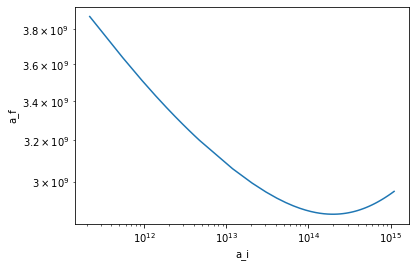

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math




             
yr=3.154e7
π=np.pi
c=3e8                  #in units of m s^-1
t_eq=1.59246e12        # in units of seconds
ρ_eq=2.15368e-16       # in units of kg.m^-3
G=6.67e-11             # in units of m^3.kg^-1.s^-2          
a_eq=2.9374e-4         # scale factor corresponding to matter radiation equlaity
t_i=13.78e9*yr         # in seconds
M_solar=1.989e30       # in units of kg


M_1PBH=1e-3*M_solar     # in units of kg
M_2PBH=1*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_1_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_1_list[i] = semi(λ_0,x)




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_1_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_1_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_1_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_1_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_1_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_1_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_1_list,a_f_1_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

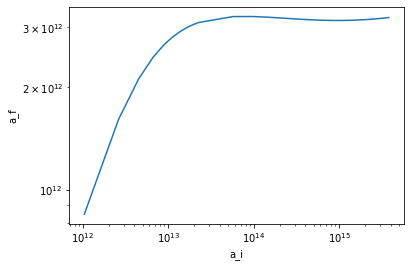

In [2]:
M_1PBH=100*M_solar     # in units of kg
M_2PBH=10*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_2_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_2_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_2_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_2_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_2_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_2_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_2_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_2_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_2_list,a_f_2_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

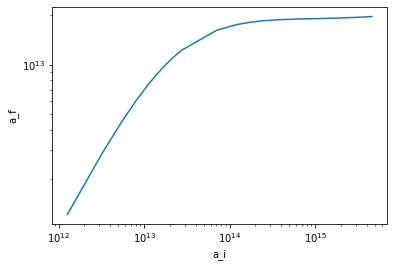

In [3]:
M_1PBH=100*M_solar     # in units of kg
M_2PBH=100*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_3_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_3_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_3_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    



def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_3_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_3_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_3_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_3_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_3_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_3_list,a_f_3_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

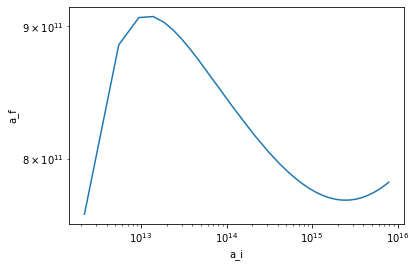

In [4]:
M_1PBH=1000*M_solar     # in units of kg
M_2PBH=10*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_4_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_4_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_4_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_4_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_4_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_4_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_4_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_4_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_4_list,a_f_4_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

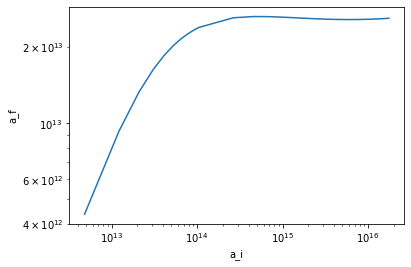

In [5]:
M_1PBH=1e4*M_solar     # in units of kg
M_2PBH=1000*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_5_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_5_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_5_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_5_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_5_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_5_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_5_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_5_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_5_list,a_f_5_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

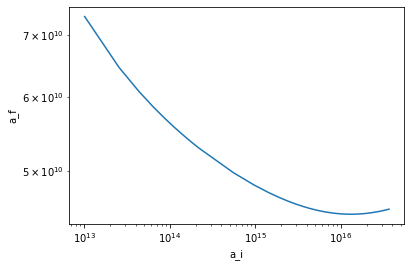

In [6]:
M_1PBH=1e5*M_solar     # in units of kg
M_2PBH=10*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_6_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_6_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_6_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_6_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_6_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_6_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_6_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_6_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_6_list,a_f_6_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

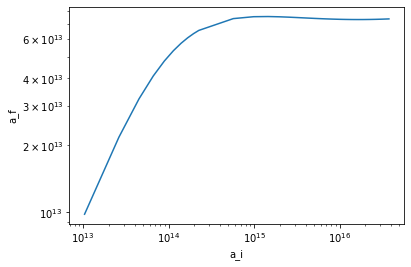

In [7]:
M_1PBH=1e5*M_solar     # in units of kg
M_2PBH=1e4*M_solar      # in units of kg


λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]



x_list=np.zeros(len(λ_list))

def x(M_1PBH,M_2PBH,λ_0): #λ_0 for the PBH binary
     return (((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))

for k, λ_0 in enumerate (λ_list):
     x_list[k]=x(M_1PBH,M_2PBH,λ_0) 


        
def M_halo(M_PBH,s):               #eq.(4) in reference pdf "M_DM at s_dec".
    return (((8*π*G*ρ_eq*(t_eq**(2)))/3)**(3/4))*(2**(5/4))*M_PBH* math.sqrt((((2/3)*(s-2)
                                *math.sqrt(s+1))+(4/3)))

def s_dec(λ_0):
    return (λ_0*s)

def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
def n(s):
    return (1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH)))
                   
def  k(s):
    return (1/n(s))


def λ(s):
    return λ_0*k(s)
   






def s_(λ_0):
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    
    plt.xlabel('s/λ_0')
    plt.ylabel('χ/λ_0')
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=As[i]
        if Δ<0:
            break
        
    return s
    
    
s_list=np.zeros(len(λ_list))
s_dec_list=np.zeros(len(λ_list))
M_halo_1_list = np.zeros(len(λ_list))
M_halo_2_list = np.zeros(len(λ_list))



for i, λ_0 in enumerate(λ_list):
    s_list[i] = s_(λ_0)

for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
for i,s in enumerate(s_dec_list):
    M_halo_1_list[i]=M_halo(M_1PBH,s)
    
for i,s in enumerate(s_dec_list):
    M_halo_2_list[i]=M_halo(M_2PBH,s)   
    





def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=(((A/2)*λ_0))                   #as Bs=separations/λ_0.
        if Δ<0:
            
            break
    
    
    return a

def semi(λ_0,x):
    return (a(λ_0)*x)


a_i_7_list=np.zeros(len(λ_list))
for i, (λ_0,x) in enumerate (zip(λ_list,x_list)):
    a_i_7_list[i] = semi(λ_0,x)
    




def M_(M_PBH,M_DM):
    return (M_PBH+M_DM)
            

    
M_1_list=np.zeros(len(λ_list))
M_2_list=np.zeros(len(λ_list))

for i, M_DM in enumerate (M_halo_1_list):
    M_1_list[i] = M_(M_1PBH,M_DM)
    
for i, M_DM in enumerate (M_halo_2_list):
    M_2_list[i]=M_(M_2PBH,M_DM)





def j_i(M_1,M_2,a_i):
    return  ((((85/3)*(G**3)*M_1*M_2*(M_1+M_2)*t_i)/((a_i**4)*(c**5)))**(1/7))

j_i_list=np.zeros(len(M_1_list))


for k, (M_1,M_2,a_i) in enumerate (zip(M_1_list,M_2_list,a_i_7_list)):
    j_i_list[k]=j_i(M_1,M_2,a_i)
    

            

    
def e_i(j_i):
    return ((1-(j_i**2))**(1/2))

e_i_list=np.zeros(len(j_i_list))

for k, j_i in enumerate(j_i_list):
    e_i_list[k]=e_i(j_i)
    




def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

r_min_list=np.zeros(len(a_i_7_list))
for k, (e_i,a_i) in enumerate (zip(e_i_list,a_i_7_list)):
     r_min_list[k]=r_min(e_i,a_i)






def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/2))*((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*(t_dec(s_dec)**2))**(1/3))

r_ta_1_list=np.zeros(len(λ_list))
r_ta_2_list=np.zeros(len(λ_list))

for j, s_dec in enumerate (s_dec_list):
    r_ta_1_list[j]=r_ta(M_1PBH,s_dec)
    r_ta_2_list[j]=r_ta(M_2PBH,s_dec)
    

    
def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def E_1(M_PBH,r_ta,r_min):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta)**(-1/4))-((r_min/2)**(-1/4))))

def E_2(M_PBH,r_ta,r_min):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*(((r_ta)**(1/2))-((r_min/2)**(1/2))))

def E_b(E_1,E_2):#Binding  energy of the dark matter halo
    return ((E_1-E_2))






E_1_1PBH_list=np.zeros(len(r_min_list))
E_2_1PBH_list=np.zeros(len(r_min_list))
E_1_2PBH_list=np.zeros(len(r_min_list))
E_2_2PBH_list=np.zeros(len(r_min_list))

for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_1PBH_list[i] = E_1(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_1_2PBH_list[i] = E_1(M_2PBH,r_ta,r_min)
    



for i, (r_ta,r_min) in enumerate (zip(r_ta_1_list,r_min_list)):
    E_2_1PBH_list[i] = E_2(M_1PBH,r_ta,r_min)
for i, (r_ta,r_min) in enumerate (zip(r_ta_2_list,r_min_list)):    
    E_2_2PBH_list[i] = E_2(M_2PBH,r_ta,r_min)

    

    
E_b_1PBH_list=np.zeros(len(r_min_list))
E_b_2PBH_list=np.zeros(len(r_min_list))

for i, (E_1,E_2) in enumerate (zip(E_1_1PBH_list,E_2_1PBH_list)):
    E_b_1PBH_list[i]=E_b(E_1,E_2)
    
for i, (E_1,E_2) in enumerate (zip(E_1_2PBH_list,E_2_2PBH_list)):
    E_b_2PBH_list[i]=E_b(E_1,E_2)
    




        
def M_halo(M_PBH,r): #Mass of the dark matter halos of size r<r_ta
    return ((16/3)*π*ρ_bar(M_PBH)*((r/2)**(3/4)))

M_halo_1f_list=np.zeros(len(λ_list))
M_halo_2f_list=np.zeros(len(λ_list))


for i, r in enumerate (r_min_list):
    M_halo_1f_list[i] = M_halo(M_1PBH,r)
    
for i, r in enumerate (r_min_list):
    M_halo_2f_list[i] = M_halo(M_2PBH,r)
    




def M_(M_PBH,M_halo):
    return (M_PBH+M_halo)


M_1f_list=np.zeros(len(λ_list))
M_2f_list=np.zeros(len(λ_list))

for i, M_halo in enumerate (M_halo_1f_list):
    M_1f_list[i] =  M_(M_1PBH,M_halo)
    
for i, M_halo in enumerate (M_halo_2f_list):
    M_2f_list[i] =  M_(M_2PBH,M_halo)
    
    


def a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2): #Final semi-major axis
    return ((G*M_1f*M_2f*a_i)/((G*M_1i*M_2i)-(2*a_i*(E_b_1+E_b_2))))


a_f_7_list=np.zeros(len(r_min_list))

for i, (a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2) in enumerate (zip(a_i_7_list,M_1_list,M_2_list,M_1f_list,M_2f_list,E_b_1PBH_list,E_b_2PBH_list)):
    a_f_7_list[i]=a_f(a_i,M_1i,M_2i,M_1f,M_2f,E_b_1,E_b_2)
    


plt.loglog(a_i_7_list,a_f_7_list,'')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.show()

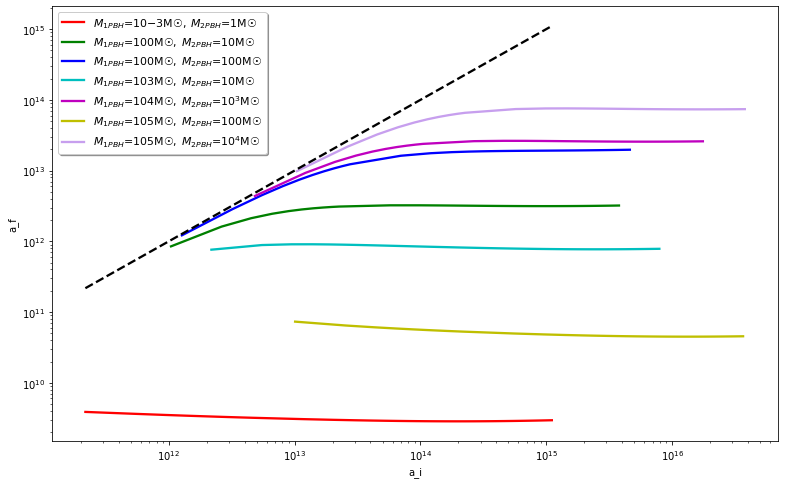

In [39]:

a_f_list=np.zeros(len(a_i_1_list))

def a_f(a_i):
    return a_i

for i, a_i in enumerate(a_i_1_list):
    a_f_list[i]=a_f(a_i)
    
    
    
    
plt.figure(figsize=(13,8))


plt.rc('lines', linewidth=2.3)


plt.loglog(a_i_1_list,a_f_1_list,'r')
plt.loglog(a_i_2_list,a_f_2_list,'g')
plt.loglog(a_i_3_list,a_f_3_list,'b')
plt.loglog(a_i_4_list,a_f_4_list,'c')
plt.loglog(a_i_5_list,a_f_5_list,'m')
plt.loglog(a_i_6_list,a_f_6_list,'y')
plt.loglog(a_i_7_list,a_f_7_list,'#C79FEE')

plt.loglog(a_i_list,a_f_list,'k--')
plt.xlabel("a_i")
plt.ylabel("a_f")
plt.legend(["$M_{1PBH}$=$10{-3}$M☉,$\hspace{0.1}$ $M_{2PBH}$=$1$M☉","$M_{1PBH}$=$100$M☉,$\hspace{0.1}$ $M_{2PBH}$=$10$M☉","$M_{1PBH}$=$100$M☉,$\hspace{0.1}$ $M_{2PBH}$=$100$M☉","$M_{1PBH}$=$10{3}$M☉,$\hspace{0.1}$ $M_{2PBH}$=$10$M☉","$M_{1PBH}$=$10{4}$M☉,$\hspace{0.1}$ $M_{2PBH}$=$10^{3}$M☉","$M_{1PBH}$=$10{5}$M☉,$\hspace{0.1}$ $M_{2PBH}$=$100$M☉","$M_{1PBH}$=$10{5}$M☉,$\hspace{0.1}$ $M_{2PBH}$=$10^{4}$M☉"],
           prop = {'size' :11},loc='upper left',shadow = True, facecolor = 'white',fontsize=19)


plt.show()